In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip3 install dataframe_image

In [3]:
import numpy as np
from pandas import DataFrame
import dataframe_image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from kirill_korolev_v1 import pa, pb, pc, pd, pc_ab, pc_abd, pc_d, pc_a, pc_b, pd_c

/Users/kirillkorolev/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
sns.set_theme(style='whitegrid')

In [5]:
class Distribution:
    def __init__(self, pfunc, params, model, *args):
        probs, values = pfunc(*args, params, model)
        self.pfunc = pfunc
        self.probs = probs
        self.values = values
        self.params = params
        self.model = model
        self.args = args
    
    def k_moment(self, k):
        values = self.values ** k
        result = np.tensordot(values, self.probs, axes=1)
        if len(result.shape) == 0:
            return result.item()
        return result

    def expectation(self):
        return self.k_moment(1)

    def variance(self):
        return self.k_moment(2) - (self.expectation()**2)

In [6]:
params = {'amin': 75, 'amax': 90, 'bmin': 500, 'bmax': 600,
              'p1': 0.1, 'p2': 0.01, 'p3': 0.3}

In [7]:
def calculate_statistics(dists):
    expectations = {}
    variances = {}

    for dist_name, dist in dists.items():
        expectations[dist_name] = dist.expectation()
        variances[dist_name] = dist.variance()
    
    stats = DataFrame(index=dists.keys(), columns=['expectation', 'variance'])
    stats['expectation'] = expectations.values()
    stats['variance'] = variances.values()
    stats = stats.astype(float).round(3)

    return stats

## Задание 2

In [8]:
dists = {'pa': Distribution(pa, params, 1), 'pb': Distribution(pb, params, 1),
         'pc1': Distribution(pc, params, 1), 'pc2': Distribution(pc, params, 2),
         'pd1': Distribution(pd, params, 1), 'pd2': Distribution(pd, params, 2)}

prior_stats = calculate_statistics(dists)
prior_stats

,expectation,variance
pa,82.500,21.250
pb,550.000,850.000
pc1,13.750,13.168
pc2,13.750,14.048
pd1,17.875,25.141
pd2,17.875,26.628


In [9]:
#prior_stats_styled = prior_stats.style.background_gradient()
#dataframe_image.export(prior_stats, 'prior_stats.png')

## Задание 3

In [10]:
a_exp = round(dists['pa'].expectation())
b_exp = round(dists['pb'].expectation())
d_exp = round(dists['pd1'].expectation())

In [11]:
dists2 = {}
dists2['pc'] = Distribution(pc, params, 1)
dists2['pc_a'] = Distribution(pc_a, params, 1, np.array([a_exp]))
dists2['pc_b'] = Distribution(pc_b, params, 1, np.array([b_exp]))
dists2['pc_d'] = Distribution(pc_d, params, 1, np.array([d_exp]))
dists2['pc_ab'] = Distribution(pc_ab, params, 1, np.array([a_exp]), np.array([b_exp]))
dists2['pc_abd'] = Distribution(pc_abd, params, 1, np.array([a_exp]), np.array([b_exp]), np.array([d_exp]))
dists2['pc2'] = Distribution(pc, params, 2)
dists2['pc_a2'] = Distribution(pc_a, params, 2, np.array([a_exp]))
dists2['pc_b2'] = Distribution(pc_b, params, 2, np.array([b_exp]))
dists2['pc_d2'] = Distribution(pc_d, params, 2, np.array([d_exp]))
dists2['pc_ab2'] = Distribution(pc_ab, params, 2, np.array([a_exp]), np.array([b_exp]))
dists2['pc_abd2'] = Distribution(pc_abd, params, 2, np.array([a_exp]), np.array([b_exp]), np.array([d_exp]))

In [12]:
cond_stats = calculate_statistics(dists2)
cond_stats

,expectation,variance
pc,13.750,13.168
pc_a,13.700,12.910
pc_b,13.750,13.083
pc_d,13.896,1.534
pc_ab,13.700,12.825
pc_abd,13.891,1.529
pc2,13.750,14.048
pc_a2,13.700,13.785
pc_b2,13.750,13.963
pc_d2,13.894,1.544


In [13]:
#dataframe_image.export(cond_stats, 'cond_stats.png')

In [14]:
models1 = {dist_name:dist for dist_name, dist in dists2.items() if dist_name[-1] != '2'}
models2 = {dist_name:dist for dist_name, dist in dists2.items() if dist_name[-1] == '2'}

def plot_dists(ax, dists, title):
    colors = ['orange', 'blue', 'red', 'green', 'pink', 'brown']
    linestyles = [
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
    
    for i, (dist_name, dist) in enumerate(dists.items()):
        probs = dist.probs.flatten()
        sns.lineplot(data=probs, linestyle=linestyles[i][1], linewidth=3, estimator=None, alpha=0.6, ax=ax, label=dist_name)
        #ax.fill_between(dist.values, probs, where=(probs > 0), color='orange', alpha=.2)
    
    ax.set_title(title)
    ax.set_xlabel('values')
    ax.set_ylabel('p')
    ax.set_xlim((0, 50))

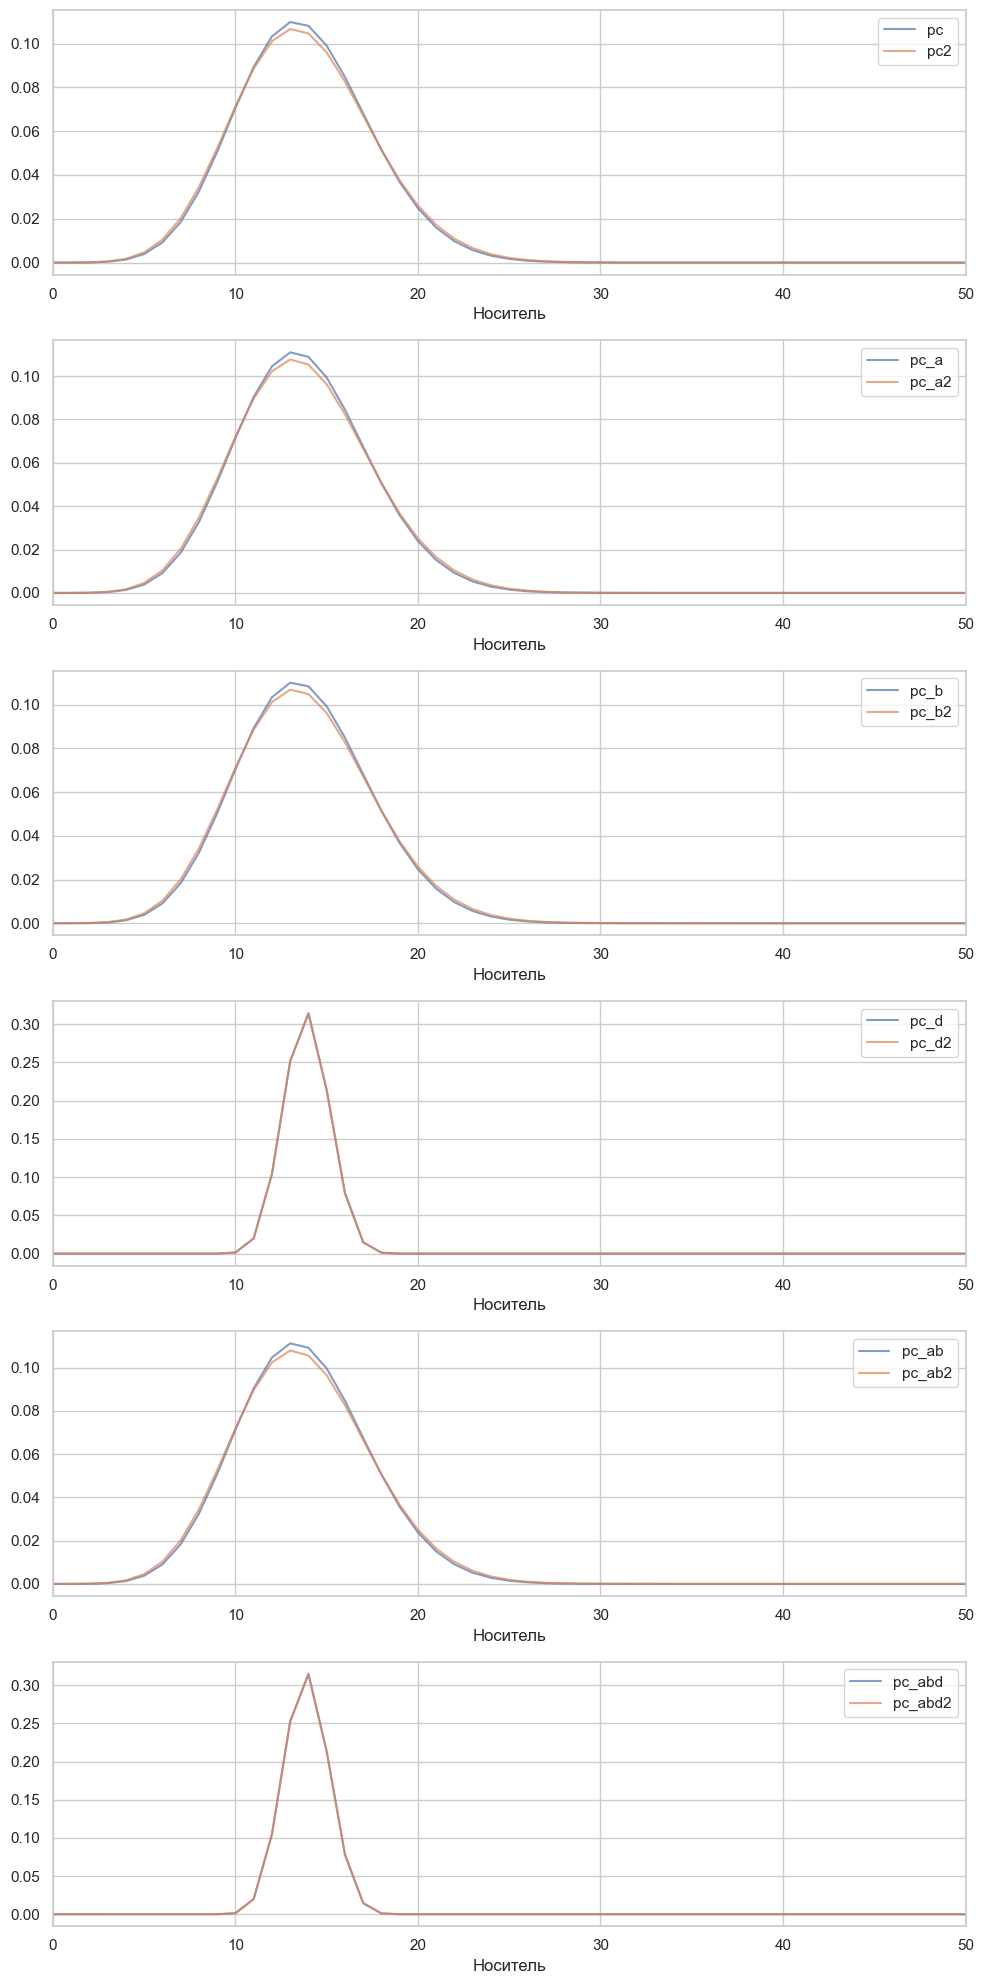

In [88]:
fig, ax = plt.subplots(len(models1), 1, figsize=(10, 20))

for i, dist_name in enumerate(models1):
    sns.lineplot(data=models1[dist_name].probs.flatten(), ax=ax[i], alpha=0.7, label=dist_name)
    sns.lineplot(data=models2[f'{dist_name}2'].probs.flatten(), ax=ax[i], alpha=0.7, label=f'{dist_name}2')
    ax[i].set_xlim((0,50))
    ax[i].set_xlabel('Носитель')

plt.tight_layout()
plt.show()

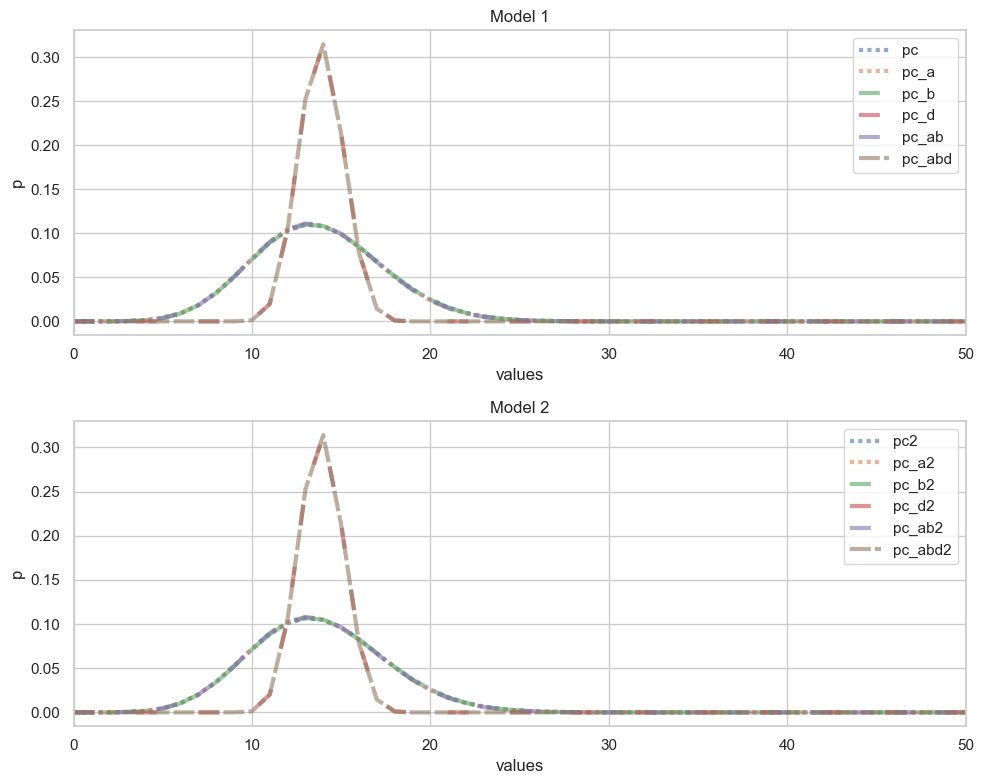

In [15]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8))

plot_dists(ax0, models1, 'Model 1')
plot_dists(ax1, models2, 'Model 2')

plt.tight_layout()
plt.show()

## Задание 4

In [16]:
dists3 = {}

dists3['pc_a'] = Distribution(pc_a, params, 1, dists['pa'].values)
dists3['pc_b'] = Distribution(pc_b, params, 1, dists['pb'].values)
dists3['pc_d'] = Distribution(pc_d, params, 1, dists['pd1'].values)
dists3['pc_a2'] = Distribution(pc_a, params, 2, dists['pa'].values)
dists3['pc_b2'] = Distribution(pc_b, params, 2, dists['pb'].values)
dists3['pc_d2'] = Distribution(pc_d, params, 2, dists['pd2'].values)

variances = {}

for dist_name, dist in dists3.items():
    variances[dist_name] = dist.variance()

In [57]:
def compare_vars(vars1, vars2):
    vars1, vars2 = np.meshgrid(vars1, vars2)
    return np.all(vars1 < vars2)

def plot_variances(ax, variances, dist_names, title):
    for dist_name in dist_names:
        sns.scatterplot(data=variances[dist_name], label=dist_name, ax=ax)

    ax.set_title(title)
    ax.set_ylabel('Дисперсия')
    ax.set_xlabel('Носитель')

Модель 1. $D[c|d] < D[c|a]$ и $D[c|d] < D[c|b]$ для любых $a,b,d$?

In [58]:
compare_vars(variances['pc_d'], variances['pc_a']), compare_vars(variances['pc_d'], variances['pc_b'])

(True, True)

Модель 2. $D[c|d] < D[c|a]$ и $D[c|d] < D[c|b]$ для любых $a,b,d$?

In [59]:
compare_vars(variances['pc_d2'], variances['pc_a2']), compare_vars(variances['pc_d2'], variances['pc_b2'])

(False, False)

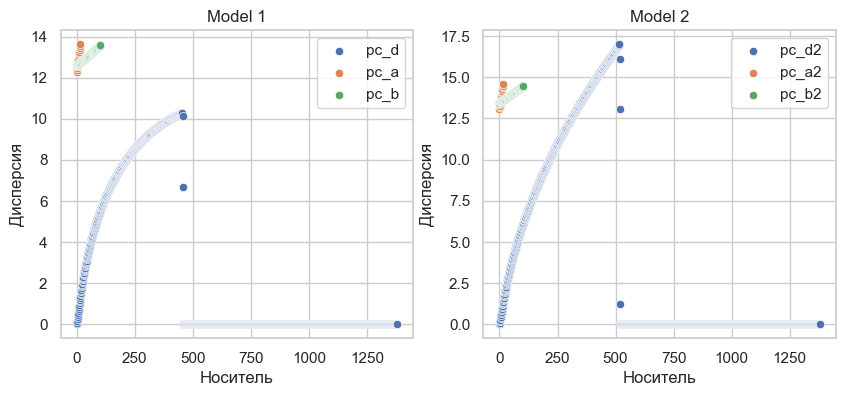

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_variances(ax[0], variances, ['pc_d', 'pc_a', 'pc_b'], 'Model 1')
plot_variances(ax[1], variances, ['pc_d2', 'pc_a2', 'pc_b2'], 'Model 2')
plt.show()

In [62]:
def find_line(params, model):
    p1 = params['p1']
    p2 = params['p2']
    Ea = dists['pa'].expectation()
    Eb = dists['pb'].expectation()
    Da = dists['pa'].variance()
    Db = dists['pb'].variance()
    a = dists['pa'].values
    if model == 1:
        b = (p1*(1-p1)*a + p2*(1-p2)*Eb + p2*p2*Db - p1*(1-p1)*Ea - p1*p1*Da) / p2 / (1-p2)
        return a, b
    b = (p1*a + p2*Eb + p2*p2*Db - p1*Ea - p1*p1*Da) / p2
    return a, b

def plot_heatmap(ax, params, model, variances, title):
    a, b = find_line(params, model)
    a = a - params['amin']
    b = b - params['bmin']
    suf = '2' if model == 2 else ''
    vars1, vars2 = np.meshgrid(variances[f'pc_a{suf}'], variances[f'pc_b{suf}'])
    vars_mask = vars1 < vars2

    ax.pcolor(vars_mask)
    sns.lineplot(x=a, y=b, ax=ax)
    ax.set_xticks(ticks=range(len(dists['pa'].values)), labels=list(map(str, dists['pa'].values)))
    ax.set_yticks(ticks=range(0, len(dists['pb'].values), 10), labels=list(map(str, dists['pb'].values[::10])))
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_ylim((0, 100))
    ax.set_title(title)

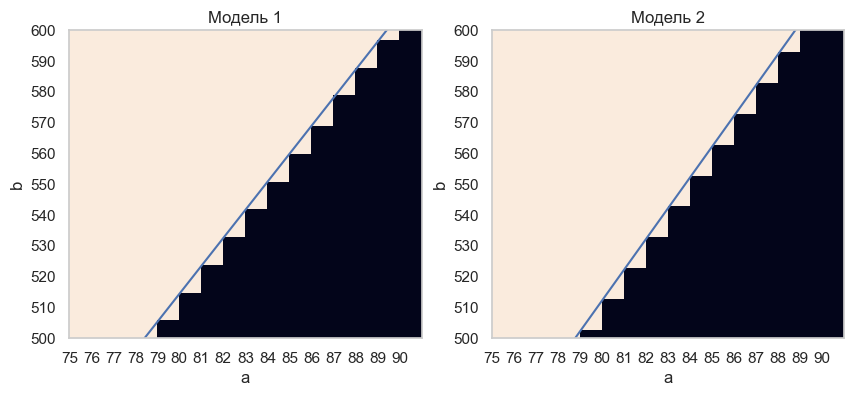

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_heatmap(ax[0], params, 1, variances, 'Модель 1')
plot_heatmap(ax[1], params, 2, variances, 'Модель 2')

plt.show()

## Задание 5

В качестве условий подаем весь носитель.

In [24]:
%%time
probs, vals = pc(params, 1)

CPU times: user 665 ms, sys: 11 ms, total: 676 ms
Wall time: 719 ms


In [25]:
%%time
probs, vals = pc(params, 2)

CPU times: user 71.4 ms, sys: 21.9 ms, total: 93.2 ms
Wall time: 120 ms


In [26]:
%%time
probs, vals = pc_a(dists['pa'].values, params, 1)

CPU times: user 650 ms, sys: 10.5 ms, total: 660 ms
Wall time: 689 ms


In [27]:
%%time
probs, vals = pc_a(dists['pa'].values, params, 2)

CPU times: user 61.7 ms, sys: 15.6 ms, total: 77.3 ms
Wall time: 79.2 ms


In [28]:
%%time
probs, vals = pc_b(dists['pb'].values, params, 1)

CPU times: user 623 ms, sys: 8.15 ms, total: 631 ms
Wall time: 639 ms


In [29]:
%%time
probs, vals = pc_b(dists['pb'].values, params, 2)

CPU times: user 61.2 ms, sys: 15.1 ms, total: 76.3 ms
Wall time: 75.2 ms


In [30]:
%%time
probs, vals = pc_d(dists['pd1'].values, params, 1)

CPU times: user 673 ms, sys: 18.5 ms, total: 692 ms
Wall time: 698 ms


In [31]:
%%time
probs, vals = pc_d(dists['pd1'].values, params, 2)

CPU times: user 120 ms, sys: 24.6 ms, total: 145 ms
Wall time: 144 ms


In [32]:
%%time
probs, vals = pc_ab(dists['pa'].values, dists['pb'].values, params, 1)

CPU times: user 628 ms, sys: 7.63 ms, total: 636 ms
Wall time: 640 ms


In [33]:
%%time
probs, vals = pc_ab(dists['pa'].values, dists['pb'].values, params, 2)

CPU times: user 68 ms, sys: 24.2 ms, total: 92.1 ms
Wall time: 100 ms


In [34]:
%%time
probs, vals = pc_abd(dists['pa'].values, dists['pb'].values, dists['pd1'].values, params, 1)

CPU times: user 21.2 s, sys: 31 s, total: 52.2 s
Wall time: 59.9 s


In [35]:
%%time
probs, vals = pc_abd(dists['pa'].values, dists['pb'].values, dists['pd1'].values, params, 2)

CPU times: user 20.3 s, sys: 31.7 s, total: 52 s
Wall time: 1min


In [36]:
%%time
probs, vals = pd(params, 1)

CPU times: user 669 ms, sys: 368 ms, total: 1.04 s
Wall time: 1.06 s


In [37]:
%%time
probs, vals = pd(params, 2)

CPU times: user 116 ms, sys: 21.2 ms, total: 137 ms
Wall time: 137 ms
